<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_07/Part_2_01_custom_lr_dropout_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Step 2: OneCycle-like Scheduler using LearningRateScheduler
def one_cycle_lr_schedule(epoch, lr):
    max_lr = 0.01
    total_epochs = 5
    pct = epoch / total_epochs
    if pct < 0.3:
        return max_lr * (pct / 0.3)
    else:
        return max_lr * (1 - pct)

lr_scheduler = keras.callbacks.LearningRateScheduler(one_cycle_lr_schedule)

In [3]:
# Step 3: Custom Dropout
class CustomAlphaDropout(layers.Layer):
    def __init__(self, rate):
        super().__init__()
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            noise = tf.cast(tf.random.uniform(tf.shape(inputs)) > self.rate, tf.float32)
            return inputs * noise
        return inputs

In [4]:
# Step 4: Custom MaxNorm Dense
class MaxNormDense(layers.Layer):
    def __init__(self, units, max_norm=2):
        super().__init__()
        self.units = units
        self.max_norm = max_norm

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=(input_shape[-1], self.units),
            initializer='glorot_uniform'
        )
        self.bias = self.add_weight(
            name="bias", shape=(self.units,),
            initializer='zeros'
        )

    def call(self, inputs):
        normed_kernel = tf.clip_by_norm(self.kernel, clip_norm=self.max_norm, axes=0)
        return tf.matmul(inputs, normed_kernel) + self.bias

In [5]:
# Step 5: Load and Preprocess Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28*28) / 255.0
x_test = x_test.reshape(-1, 28*28) / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Step 6: Build Model
model = keras.Sequential([
    keras.Input(shape=(784,)),
    MaxNormDense(256),
    layers.Activation("relu"),
    CustomAlphaDropout(0.3),
    MaxNormDense(128),
    layers.Activation("relu"),
    CustomAlphaDropout(0.3),
    layers.Dense(10, activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [7]:
# Step 7: Train with new scheduler
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr_scheduler]
)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.0785 - loss: 2.3412 - val_accuracy: 0.0768 - val_loss: 2.3677 - learning_rate: 0.0000e+00
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8434 - loss: 0.5062 - val_accuracy: 0.9513 - val_loss: 0.2088 - learning_rate: 0.0067
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9446 - loss: 0.1875 - val_accuracy: 0.9601 - val_loss: 0.1936 - learning_rate: 0.0060
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9587 - loss: 0.1394 - val_accuracy: 0.9690 - val_loss: 0.1367 - learning_rate: 0.0040
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.9691 - loss: 0.0989 - val_accuracy: 0.9746 - val_loss: 0.1192 - learning_rate: 0.0020


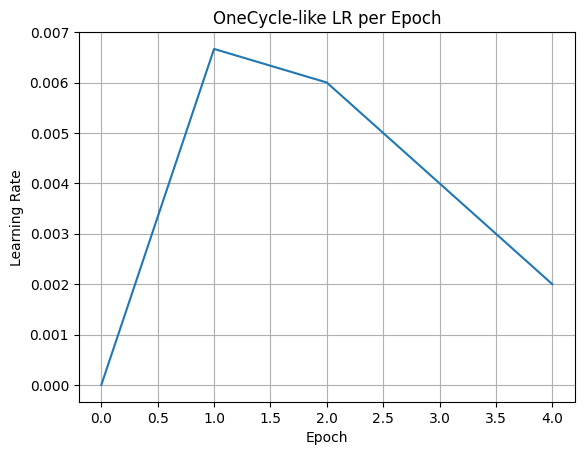

In [8]:
# Step 8: Plot learning rate per epoch
lrs = [one_cycle_lr_schedule(epoch, 0) for epoch in range(5)]
plt.plot(lrs)
plt.title("OneCycle-like LR per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()
